In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.OneHeadModel import OneHeadModel

import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [2]:
allow_train = True
load_pre_train_model = True
freeze_encoder = False
EPOCHS = 70
BATCH_SIZE = 256
shrink_size = None

lr = 3e-3
weight_deacay = 1e-4
T_max = 70
eta_min = 3e-6
num_augs = 3
p_dropout = 0.4
pos_weight = torch.tensor([3.0])

crop_size = 380
th = 0.0

# alpha = 1
# gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

In [5]:
# load all dataloaders

train_dataloader, val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_train_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=test_transforms,
    shrink_size=shrink_size)

MESSIDOR_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='MESSIDOR',
    shrink_size=shrink_size)   

IDRID_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='IDRID',
    shrink_size=shrink_size) 

APTOS_15_test_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='APTOS_15_test',
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.2489083].


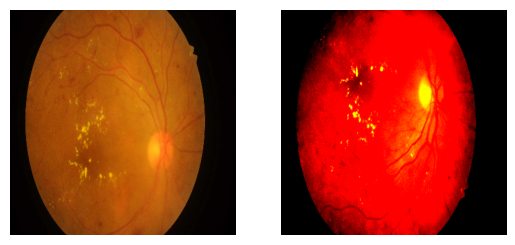

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
def prepare_model():
    if load_pre_train_model:
        model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

        # nn.init.kaiming_normal_(model.dense1.weight, mode='fan_in', nonlinearity='relu')
        # if model.dense1.bias is not None:
        #     nn.init.zeros_(model.dense1.bias)

        for module in model.classification_head:
            if isinstance(module, nn.Linear):
                # Apply He initialization to weights
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                # Initialize biases to zero (optional, common practice)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)


In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, crop_size, crop_size), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                                  [32, 3, 380, 380]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 380, 380]    [32, 1280, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 380, 380]    [32, 32, 190, 190]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 380, 380]    [32, 32, 190, 190]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 190, 190]   [32, 32, 190, 190]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 190, 190]   [32, 32, 190, 190]   --                   --
│    └─Sequential (1)                                        [32, 32, 190, 190]   [32, 16, 190

Custom Focal Loss function

In [10]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [11]:
from going_modular.focal_loss import FocalLoss

In [12]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

loss_fn_classification = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='multi-class', num_classes=5).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='binary', num_classes=2).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [13]:
model = torch.compile(model)

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results

    prepare_model() # restet model's weights to pre train for each fold

    print('\nFirst the encoder is frozen for 5 epochs...\n')

    # Freeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    # training for 5 epochs to save pre train weights
    _, _ = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=5,
                device=device)
    
    # resetting the scheduler
    # scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    print('\nNow the encoder will be trained...\n')
    
    # UnFreeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = True

    train_results, val_results = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=EPOCHS,
                device=device)
    
    helper_functions.plot_t_SNE(model=model,
                            dataloader=val_dataloader,
                            NUM_ITER=2000)
    
    utils.save_model(model=model, target_dir='models', model_name=f'main_train_model.pth')


    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

RuntimeError: Error(s) in loading state_dict for OptimizedModule:
	Missing key(s) in state_dict: "_orig_mod.dense1.0.weight", "_orig_mod.dense1.0.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.encoder.2.3.block.0.0.weight", "_orig_mod.encoder.2.3.block.0.1.weight", "_orig_mod.encoder.2.3.block.0.1.bias", "_orig_mod.encoder.2.3.block.0.1.running_mean", "_orig_mod.encoder.2.3.block.0.1.running_var", "_orig_mod.encoder.2.3.block.0.1.num_batches_tracked", "_orig_mod.encoder.2.3.block.1.0.weight", "_orig_mod.encoder.2.3.block.1.1.weight", "_orig_mod.encoder.2.3.block.1.1.bias", "_orig_mod.encoder.2.3.block.1.1.running_mean", "_orig_mod.encoder.2.3.block.1.1.running_var", "_orig_mod.encoder.2.3.block.1.1.num_batches_tracked", "_orig_mod.encoder.2.3.block.2.fc1.weight", "_orig_mod.encoder.2.3.block.2.fc1.bias", "_orig_mod.encoder.2.3.block.2.fc2.weight", "_orig_mod.encoder.2.3.block.2.fc2.bias", "_orig_mod.encoder.2.3.block.3.0.weight", "_orig_mod.encoder.2.3.block.3.1.weight", "_orig_mod.encoder.2.3.block.3.1.bias", "_orig_mod.encoder.2.3.block.3.1.running_mean", "_orig_mod.encoder.2.3.block.3.1.running_var", "_orig_mod.encoder.2.3.block.3.1.num_batches_tracked", "_orig_mod.encoder.3.3.block.0.0.weight", "_orig_mod.encoder.3.3.block.0.1.weight", "_orig_mod.encoder.3.3.block.0.1.bias", "_orig_mod.encoder.3.3.block.0.1.running_mean", "_orig_mod.encoder.3.3.block.0.1.running_var", "_orig_mod.encoder.3.3.block.0.1.num_batches_tracked", "_orig_mod.encoder.3.3.block.1.0.weight", "_orig_mod.encoder.3.3.block.1.1.weight", "_orig_mod.encoder.3.3.block.1.1.bias", "_orig_mod.encoder.3.3.block.1.1.running_mean", "_orig_mod.encoder.3.3.block.1.1.running_var", "_orig_mod.encoder.3.3.block.1.1.num_batches_tracked", "_orig_mod.encoder.3.3.block.2.fc1.weight", "_orig_mod.encoder.3.3.block.2.fc1.bias", "_orig_mod.encoder.3.3.block.2.fc2.weight", "_orig_mod.encoder.3.3.block.2.fc2.bias", "_orig_mod.encoder.3.3.block.3.0.weight", "_orig_mod.encoder.3.3.block.3.1.weight", "_orig_mod.encoder.3.3.block.3.1.bias", "_orig_mod.encoder.3.3.block.3.1.running_mean", "_orig_mod.encoder.3.3.block.3.1.running_var", "_orig_mod.encoder.3.3.block.3.1.num_batches_tracked", "_orig_mod.encoder.4.4.block.0.0.weight", "_orig_mod.encoder.4.4.block.0.1.weight", "_orig_mod.encoder.4.4.block.0.1.bias", "_orig_mod.encoder.4.4.block.0.1.running_mean", "_orig_mod.encoder.4.4.block.0.1.running_var", "_orig_mod.encoder.4.4.block.0.1.num_batches_tracked", "_orig_mod.encoder.4.4.block.1.0.weight", "_orig_mod.encoder.4.4.block.1.1.weight", "_orig_mod.encoder.4.4.block.1.1.bias", "_orig_mod.encoder.4.4.block.1.1.running_mean", "_orig_mod.encoder.4.4.block.1.1.running_var", "_orig_mod.encoder.4.4.block.1.1.num_batches_tracked", "_orig_mod.encoder.4.4.block.2.fc1.weight", "_orig_mod.encoder.4.4.block.2.fc1.bias", "_orig_mod.encoder.4.4.block.2.fc2.weight", "_orig_mod.encoder.4.4.block.2.fc2.bias", "_orig_mod.encoder.4.4.block.3.0.weight", "_orig_mod.encoder.4.4.block.3.1.weight", "_orig_mod.encoder.4.4.block.3.1.bias", "_orig_mod.encoder.4.4.block.3.1.running_mean", "_orig_mod.encoder.4.4.block.3.1.running_var", "_orig_mod.encoder.4.4.block.3.1.num_batches_tracked", "_orig_mod.encoder.4.5.block.0.0.weight", "_orig_mod.encoder.4.5.block.0.1.weight", "_orig_mod.encoder.4.5.block.0.1.bias", "_orig_mod.encoder.4.5.block.0.1.running_mean", "_orig_mod.encoder.4.5.block.0.1.running_var", "_orig_mod.encoder.4.5.block.0.1.num_batches_tracked", "_orig_mod.encoder.4.5.block.1.0.weight", "_orig_mod.encoder.4.5.block.1.1.weight", "_orig_mod.encoder.4.5.block.1.1.bias", "_orig_mod.encoder.4.5.block.1.1.running_mean", "_orig_mod.encoder.4.5.block.1.1.running_var", "_orig_mod.encoder.4.5.block.1.1.num_batches_tracked", "_orig_mod.encoder.4.5.block.2.fc1.weight", "_orig_mod.encoder.4.5.block.2.fc1.bias", "_orig_mod.encoder.4.5.block.2.fc2.weight", "_orig_mod.encoder.4.5.block.2.fc2.bias", "_orig_mod.encoder.4.5.block.3.0.weight", "_orig_mod.encoder.4.5.block.3.1.weight", "_orig_mod.encoder.4.5.block.3.1.bias", "_orig_mod.encoder.4.5.block.3.1.running_mean", "_orig_mod.encoder.4.5.block.3.1.running_var", "_orig_mod.encoder.4.5.block.3.1.num_batches_tracked", "_orig_mod.encoder.5.4.block.0.0.weight", "_orig_mod.encoder.5.4.block.0.1.weight", "_orig_mod.encoder.5.4.block.0.1.bias", "_orig_mod.encoder.5.4.block.0.1.running_mean", "_orig_mod.encoder.5.4.block.0.1.running_var", "_orig_mod.encoder.5.4.block.0.1.num_batches_tracked", "_orig_mod.encoder.5.4.block.1.0.weight", "_orig_mod.encoder.5.4.block.1.1.weight", "_orig_mod.encoder.5.4.block.1.1.bias", "_orig_mod.encoder.5.4.block.1.1.running_mean", "_orig_mod.encoder.5.4.block.1.1.running_var", "_orig_mod.encoder.5.4.block.1.1.num_batches_tracked", "_orig_mod.encoder.5.4.block.2.fc1.weight", "_orig_mod.encoder.5.4.block.2.fc1.bias", "_orig_mod.encoder.5.4.block.2.fc2.weight", "_orig_mod.encoder.5.4.block.2.fc2.bias", "_orig_mod.encoder.5.4.block.3.0.weight", "_orig_mod.encoder.5.4.block.3.1.weight", "_orig_mod.encoder.5.4.block.3.1.bias", "_orig_mod.encoder.5.4.block.3.1.running_mean", "_orig_mod.encoder.5.4.block.3.1.running_var", "_orig_mod.encoder.5.4.block.3.1.num_batches_tracked", "_orig_mod.encoder.5.5.block.0.0.weight", "_orig_mod.encoder.5.5.block.0.1.weight", "_orig_mod.encoder.5.5.block.0.1.bias", "_orig_mod.encoder.5.5.block.0.1.running_mean", "_orig_mod.encoder.5.5.block.0.1.running_var", "_orig_mod.encoder.5.5.block.0.1.num_batches_tracked", "_orig_mod.encoder.5.5.block.1.0.weight", "_orig_mod.encoder.5.5.block.1.1.weight", "_orig_mod.encoder.5.5.block.1.1.bias", "_orig_mod.encoder.5.5.block.1.1.running_mean", "_orig_mod.encoder.5.5.block.1.1.running_var", "_orig_mod.encoder.5.5.block.1.1.num_batches_tracked", "_orig_mod.encoder.5.5.block.2.fc1.weight", "_orig_mod.encoder.5.5.block.2.fc1.bias", "_orig_mod.encoder.5.5.block.2.fc2.weight", "_orig_mod.encoder.5.5.block.2.fc2.bias", "_orig_mod.encoder.5.5.block.3.0.weight", "_orig_mod.encoder.5.5.block.3.1.weight", "_orig_mod.encoder.5.5.block.3.1.bias", "_orig_mod.encoder.5.5.block.3.1.running_mean", "_orig_mod.encoder.5.5.block.3.1.running_var", "_orig_mod.encoder.5.5.block.3.1.num_batches_tracked", "_orig_mod.encoder.6.5.block.0.0.weight", "_orig_mod.encoder.6.5.block.0.1.weight", "_orig_mod.encoder.6.5.block.0.1.bias", "_orig_mod.encoder.6.5.block.0.1.running_mean", "_orig_mod.encoder.6.5.block.0.1.running_var", "_orig_mod.encoder.6.5.block.0.1.num_batches_tracked", "_orig_mod.encoder.6.5.block.1.0.weight", "_orig_mod.encoder.6.5.block.1.1.weight", "_orig_mod.encoder.6.5.block.1.1.bias", "_orig_mod.encoder.6.5.block.1.1.running_mean", "_orig_mod.encoder.6.5.block.1.1.running_var", "_orig_mod.encoder.6.5.block.1.1.num_batches_tracked", "_orig_mod.encoder.6.5.block.2.fc1.weight", "_orig_mod.encoder.6.5.block.2.fc1.bias", "_orig_mod.encoder.6.5.block.2.fc2.weight", "_orig_mod.encoder.6.5.block.2.fc2.bias", "_orig_mod.encoder.6.5.block.3.0.weight", "_orig_mod.encoder.6.5.block.3.1.weight", "_orig_mod.encoder.6.5.block.3.1.bias", "_orig_mod.encoder.6.5.block.3.1.running_mean", "_orig_mod.encoder.6.5.block.3.1.running_var", "_orig_mod.encoder.6.5.block.3.1.num_batches_tracked", "_orig_mod.encoder.6.6.block.0.0.weight", "_orig_mod.encoder.6.6.block.0.1.weight", "_orig_mod.encoder.6.6.block.0.1.bias", "_orig_mod.encoder.6.6.block.0.1.running_mean", "_orig_mod.encoder.6.6.block.0.1.running_var", "_orig_mod.encoder.6.6.block.0.1.num_batches_tracked", "_orig_mod.encoder.6.6.block.1.0.weight", "_orig_mod.encoder.6.6.block.1.1.weight", "_orig_mod.encoder.6.6.block.1.1.bias", "_orig_mod.encoder.6.6.block.1.1.running_mean", "_orig_mod.encoder.6.6.block.1.1.running_var", "_orig_mod.encoder.6.6.block.1.1.num_batches_tracked", "_orig_mod.encoder.6.6.block.2.fc1.weight", "_orig_mod.encoder.6.6.block.2.fc1.bias", "_orig_mod.encoder.6.6.block.2.fc2.weight", "_orig_mod.encoder.6.6.block.2.fc2.bias", "_orig_mod.encoder.6.6.block.3.0.weight", "_orig_mod.encoder.6.6.block.3.1.weight", "_orig_mod.encoder.6.6.block.3.1.bias", "_orig_mod.encoder.6.6.block.3.1.running_mean", "_orig_mod.encoder.6.6.block.3.1.running_var", "_orig_mod.encoder.6.6.block.3.1.num_batches_tracked", "_orig_mod.encoder.6.7.block.0.0.weight", "_orig_mod.encoder.6.7.block.0.1.weight", "_orig_mod.encoder.6.7.block.0.1.bias", "_orig_mod.encoder.6.7.block.0.1.running_mean", "_orig_mod.encoder.6.7.block.0.1.running_var", "_orig_mod.encoder.6.7.block.0.1.num_batches_tracked", "_orig_mod.encoder.6.7.block.1.0.weight", "_orig_mod.encoder.6.7.block.1.1.weight", "_orig_mod.encoder.6.7.block.1.1.bias", "_orig_mod.encoder.6.7.block.1.1.running_mean", "_orig_mod.encoder.6.7.block.1.1.running_var", "_orig_mod.encoder.6.7.block.1.1.num_batches_tracked", "_orig_mod.encoder.6.7.block.2.fc1.weight", "_orig_mod.encoder.6.7.block.2.fc1.bias", "_orig_mod.encoder.6.7.block.2.fc2.weight", "_orig_mod.encoder.6.7.block.2.fc2.bias", "_orig_mod.encoder.6.7.block.3.0.weight", "_orig_mod.encoder.6.7.block.3.1.weight", "_orig_mod.encoder.6.7.block.3.1.bias", "_orig_mod.encoder.6.7.block.3.1.running_mean", "_orig_mod.encoder.6.7.block.3.1.running_var", "_orig_mod.encoder.6.7.block.3.1.num_batches_tracked", "_orig_mod.dense1.weight", "_orig_mod.dense1.bias". 
	size mismatch for _orig_mod.encoder.0.0.weight: copying a param with shape torch.Size([48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for _orig_mod.encoder.0.1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.0.1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.0.1.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.0.1.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.1.0.block.0.0.weight: copying a param with shape torch.Size([48, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.1.0.block.0.1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.1.0.block.0.1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.1.0.block.0.1.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.1.0.block.0.1.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.1.0.block.1.fc1.weight: copying a param with shape torch.Size([12, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 32, 1, 1]).
	size mismatch for _orig_mod.encoder.1.0.block.1.fc1.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for _orig_mod.encoder.1.0.block.1.fc2.weight: copying a param with shape torch.Size([48, 12, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 8, 1, 1]).
	size mismatch for _orig_mod.encoder.1.0.block.1.fc2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for _orig_mod.encoder.1.0.block.2.0.weight: copying a param with shape torch.Size([24, 48, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 32, 1, 1]).
	size mismatch for _orig_mod.encoder.1.0.block.2.1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.0.block.2.1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.0.block.2.1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.0.block.2.1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.0.0.weight: copying a param with shape torch.Size([24, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.1.1.block.0.1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.0.1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.0.1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.0.1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.1.fc1.weight: copying a param with shape torch.Size([6, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 16, 1, 1]).
	size mismatch for _orig_mod.encoder.1.1.block.1.fc1.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for _orig_mod.encoder.1.1.block.1.fc2.weight: copying a param with shape torch.Size([24, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 4, 1, 1]).
	size mismatch for _orig_mod.encoder.1.1.block.1.fc2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.2.0.weight: copying a param with shape torch.Size([24, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 16, 1, 1]).
	size mismatch for _orig_mod.encoder.1.1.block.2.1.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.2.1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.2.1.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.1.1.block.2.1.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for _orig_mod.encoder.2.0.block.0.0.weight: copying a param with shape torch.Size([144, 24, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 16, 1, 1]).
	size mismatch for _orig_mod.encoder.2.0.block.0.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.0.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.0.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.0.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.1.0.weight: copying a param with shape torch.Size([144, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.2.0.block.1.1.weight: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.1.1.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.1.1.running_mean: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.1.1.running_var: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.2.fc1.weight: copying a param with shape torch.Size([6, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 96, 1, 1]).
	size mismatch for _orig_mod.encoder.2.0.block.2.fc1.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for _orig_mod.encoder.2.0.block.2.fc2.weight: copying a param with shape torch.Size([144, 6, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 4, 1, 1]).
	size mismatch for _orig_mod.encoder.2.0.block.2.fc2.bias: copying a param with shape torch.Size([144]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for _orig_mod.encoder.2.0.block.3.0.weight: copying a param with shape torch.Size([32, 144, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 96, 1, 1]).
	size mismatch for _orig_mod.encoder.2.0.block.3.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.0.block.3.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.0.block.3.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.0.block.3.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.1.block.0.0.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for _orig_mod.encoder.2.1.block.0.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.0.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.0.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.0.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.1.0.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([144, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.2.1.block.1.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.1.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.1.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.1.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.2.fc1.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 144, 1, 1]).
	size mismatch for _orig_mod.encoder.2.1.block.2.fc1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for _orig_mod.encoder.2.1.block.2.fc2.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 6, 1, 1]).
	size mismatch for _orig_mod.encoder.2.1.block.2.fc2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.1.block.3.0.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 144, 1, 1]).
	size mismatch for _orig_mod.encoder.2.1.block.3.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.1.block.3.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.1.block.3.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.1.block.3.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.2.block.0.0.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for _orig_mod.encoder.2.2.block.0.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.0.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.0.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.0.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.1.0.weight: copying a param with shape torch.Size([192, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([144, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.2.2.block.1.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.1.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.1.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.1.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.2.fc1.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 144, 1, 1]).
	size mismatch for _orig_mod.encoder.2.2.block.2.fc1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for _orig_mod.encoder.2.2.block.2.fc2.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 6, 1, 1]).
	size mismatch for _orig_mod.encoder.2.2.block.2.fc2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.2.2.block.3.0.weight: copying a param with shape torch.Size([32, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 144, 1, 1]).
	size mismatch for _orig_mod.encoder.2.2.block.3.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.2.block.3.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.2.block.3.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.2.2.block.3.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([24]).
	size mismatch for _orig_mod.encoder.3.0.block.0.0.weight: copying a param with shape torch.Size([192, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 24, 1, 1]).
	size mismatch for _orig_mod.encoder.3.0.block.0.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.0.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.0.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.0.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.1.0.weight: copying a param with shape torch.Size([192, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([144, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.3.0.block.1.1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.1.1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.1.1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.1.1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.2.fc1.weight: copying a param with shape torch.Size([8, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 144, 1, 1]).
	size mismatch for _orig_mod.encoder.3.0.block.2.fc1.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for _orig_mod.encoder.3.0.block.2.fc2.weight: copying a param with shape torch.Size([192, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([144, 6, 1, 1]).
	size mismatch for _orig_mod.encoder.3.0.block.2.fc2.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for _orig_mod.encoder.3.0.block.3.0.weight: copying a param with shape torch.Size([56, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 144, 1, 1]).
	size mismatch for _orig_mod.encoder.3.0.block.3.1.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.0.block.3.1.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.0.block.3.1.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.0.block.3.1.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.1.block.0.0.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for _orig_mod.encoder.3.1.block.0.1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.0.1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.0.1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.0.1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.1.0.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.3.1.block.1.1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.1.1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.1.1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.1.1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.2.fc1.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for _orig_mod.encoder.3.1.block.2.fc1.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for _orig_mod.encoder.3.1.block.2.fc2.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for _orig_mod.encoder.3.1.block.2.fc2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.1.block.3.0.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for _orig_mod.encoder.3.1.block.3.1.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.1.block.3.1.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.1.block.3.1.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.1.block.3.1.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.2.block.0.0.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for _orig_mod.encoder.3.2.block.0.1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.0.1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.0.1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.0.1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.1.0.weight: copying a param with shape torch.Size([336, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([240, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.3.2.block.1.1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.1.1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.1.1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.1.1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.2.fc1.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for _orig_mod.encoder.3.2.block.2.fc1.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for _orig_mod.encoder.3.2.block.2.fc2.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for _orig_mod.encoder.3.2.block.2.fc2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.3.2.block.3.0.weight: copying a param with shape torch.Size([56, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 240, 1, 1]).
	size mismatch for _orig_mod.encoder.3.2.block.3.1.weight: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.2.block.3.1.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.2.block.3.1.running_mean: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.3.2.block.3.1.running_var: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for _orig_mod.encoder.4.0.block.0.0.weight: copying a param with shape torch.Size([336, 56, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 40, 1, 1]).
	size mismatch for _orig_mod.encoder.4.0.block.0.1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.0.1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.0.1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.0.1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.1.0.weight: copying a param with shape torch.Size([336, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([240, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.4.0.block.1.1.weight: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.1.1.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.1.1.running_mean: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.1.1.running_var: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.2.fc1.weight: copying a param with shape torch.Size([14, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 240, 1, 1]).
	size mismatch for _orig_mod.encoder.4.0.block.2.fc1.bias: copying a param with shape torch.Size([14]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for _orig_mod.encoder.4.0.block.2.fc2.weight: copying a param with shape torch.Size([336, 14, 1, 1]) from checkpoint, the shape in current model is torch.Size([240, 10, 1, 1]).
	size mismatch for _orig_mod.encoder.4.0.block.2.fc2.bias: copying a param with shape torch.Size([336]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for _orig_mod.encoder.4.0.block.3.0.weight: copying a param with shape torch.Size([112, 336, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 240, 1, 1]).
	size mismatch for _orig_mod.encoder.4.0.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.0.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.0.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.0.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.1.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for _orig_mod.encoder.4.1.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.1.0.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.4.1.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.4.1.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for _orig_mod.encoder.4.1.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for _orig_mod.encoder.4.1.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.1.block.3.0.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.4.1.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.1.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.1.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.1.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.2.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for _orig_mod.encoder.4.2.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.1.0.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.4.2.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.4.2.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for _orig_mod.encoder.4.2.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for _orig_mod.encoder.4.2.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.2.block.3.0.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.4.2.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.2.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.2.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.2.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.3.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for _orig_mod.encoder.4.3.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.1.0.weight: copying a param with shape torch.Size([672, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([480, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.4.3.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.4.3.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for _orig_mod.encoder.4.3.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for _orig_mod.encoder.4.3.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.4.3.block.3.0.weight: copying a param with shape torch.Size([112, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.4.3.block.3.1.weight: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.3.block.3.1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.3.block.3.1.running_mean: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.4.3.block.3.1.running_var: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.5.0.block.0.0.weight: copying a param with shape torch.Size([672, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 80, 1, 1]).
	size mismatch for _orig_mod.encoder.5.0.block.0.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.0.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.0.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.0.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.1.0.weight: copying a param with shape torch.Size([672, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([480, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.5.0.block.1.1.weight: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.1.1.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.1.1.running_mean: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.1.1.running_var: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.2.fc1.weight: copying a param with shape torch.Size([28, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.5.0.block.2.fc1.bias: copying a param with shape torch.Size([28]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for _orig_mod.encoder.5.0.block.2.fc2.weight: copying a param with shape torch.Size([672, 28, 1, 1]) from checkpoint, the shape in current model is torch.Size([480, 20, 1, 1]).
	size mismatch for _orig_mod.encoder.5.0.block.2.fc2.bias: copying a param with shape torch.Size([672]) from checkpoint, the shape in current model is torch.Size([480]).
	size mismatch for _orig_mod.encoder.5.0.block.3.0.weight: copying a param with shape torch.Size([160, 672, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 480, 1, 1]).
	size mismatch for _orig_mod.encoder.5.0.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.0.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.0.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.0.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.1.block.0.0.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for _orig_mod.encoder.5.1.block.0.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.0.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.0.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.0.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.1.0.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.5.1.block.1.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.1.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.1.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.1.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.2.fc1.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.5.1.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for _orig_mod.encoder.5.1.block.2.fc2.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for _orig_mod.encoder.5.1.block.2.fc2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.1.block.3.0.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.5.1.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.1.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.1.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.1.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.2.block.0.0.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for _orig_mod.encoder.5.2.block.0.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.0.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.0.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.0.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.1.0.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.5.2.block.1.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.1.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.1.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.1.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.2.fc1.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.5.2.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for _orig_mod.encoder.5.2.block.2.fc2.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for _orig_mod.encoder.5.2.block.2.fc2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.2.block.3.0.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.5.2.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.2.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.2.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.2.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.3.block.0.0.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for _orig_mod.encoder.5.3.block.0.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.0.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.0.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.0.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.1.0.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.5.3.block.1.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.1.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.1.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.1.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.2.fc1.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.5.3.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for _orig_mod.encoder.5.3.block.2.fc2.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for _orig_mod.encoder.5.3.block.2.fc2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.5.3.block.3.0.weight: copying a param with shape torch.Size([160, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.5.3.block.3.1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.3.block.3.1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.3.block.3.1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.5.3.block.3.1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for _orig_mod.encoder.6.0.block.0.0.weight: copying a param with shape torch.Size([960, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 112, 1, 1]).
	size mismatch for _orig_mod.encoder.6.0.block.0.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.0.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.0.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.0.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.1.0.weight: copying a param with shape torch.Size([960, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([672, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.6.0.block.1.1.weight: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.1.1.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.1.1.running_mean: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.1.1.running_var: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.2.fc1.weight: copying a param with shape torch.Size([40, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([28, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.6.0.block.2.fc1.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for _orig_mod.encoder.6.0.block.2.fc2.weight: copying a param with shape torch.Size([960, 40, 1, 1]) from checkpoint, the shape in current model is torch.Size([672, 28, 1, 1]).
	size mismatch for _orig_mod.encoder.6.0.block.2.fc2.bias: copying a param with shape torch.Size([960]) from checkpoint, the shape in current model is torch.Size([672]).
	size mismatch for _orig_mod.encoder.6.0.block.3.0.weight: copying a param with shape torch.Size([272, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 672, 1, 1]).
	size mismatch for _orig_mod.encoder.6.0.block.3.1.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.0.block.3.1.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.0.block.3.1.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.0.block.3.1.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.1.block.0.0.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for _orig_mod.encoder.6.1.block.0.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.0.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.0.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.0.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.1.0.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.6.1.block.1.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.1.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.1.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.1.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.2.fc1.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.1.block.2.fc1.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for _orig_mod.encoder.6.1.block.2.fc2.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for _orig_mod.encoder.6.1.block.2.fc2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.1.block.3.0.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.1.block.3.1.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.1.block.3.1.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.1.block.3.1.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.1.block.3.1.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.2.block.0.0.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for _orig_mod.encoder.6.2.block.0.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.0.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.0.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.0.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.1.0.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.6.2.block.1.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.1.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.1.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.1.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.2.fc1.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.2.block.2.fc1.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for _orig_mod.encoder.6.2.block.2.fc2.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for _orig_mod.encoder.6.2.block.2.fc2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.2.block.3.0.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.2.block.3.1.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.2.block.3.1.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.2.block.3.1.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.2.block.3.1.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.3.block.0.0.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for _orig_mod.encoder.6.3.block.0.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.0.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.0.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.0.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.1.0.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.6.3.block.1.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.1.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.1.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.1.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.2.fc1.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.3.block.2.fc1.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for _orig_mod.encoder.6.3.block.2.fc2.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for _orig_mod.encoder.6.3.block.2.fc2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.3.block.3.0.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.3.block.3.1.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.3.block.3.1.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.3.block.3.1.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.3.block.3.1.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.4.block.0.0.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for _orig_mod.encoder.6.4.block.0.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.0.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.0.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.0.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.1.0.weight: copying a param with shape torch.Size([1632, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([1152, 1, 5, 5]).
	size mismatch for _orig_mod.encoder.6.4.block.1.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.1.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.1.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.1.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.2.fc1.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.4.block.2.fc1.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for _orig_mod.encoder.6.4.block.2.fc2.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for _orig_mod.encoder.6.4.block.2.fc2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.6.4.block.3.0.weight: copying a param with shape torch.Size([272, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([192, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.6.4.block.3.1.weight: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.4.block.3.1.bias: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.4.block.3.1.running_mean: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.6.4.block.3.1.running_var: copying a param with shape torch.Size([272]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for _orig_mod.encoder.7.0.block.0.0.weight: copying a param with shape torch.Size([1632, 272, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 192, 1, 1]).
	size mismatch for _orig_mod.encoder.7.0.block.0.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.0.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.0.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.0.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.1.0.weight: copying a param with shape torch.Size([1632, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1152, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.7.0.block.1.1.weight: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.1.1.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.1.1.running_mean: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.1.1.running_var: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.2.fc1.weight: copying a param with shape torch.Size([68, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([48, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.7.0.block.2.fc1.bias: copying a param with shape torch.Size([68]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for _orig_mod.encoder.7.0.block.2.fc2.weight: copying a param with shape torch.Size([1632, 68, 1, 1]) from checkpoint, the shape in current model is torch.Size([1152, 48, 1, 1]).
	size mismatch for _orig_mod.encoder.7.0.block.2.fc2.bias: copying a param with shape torch.Size([1632]) from checkpoint, the shape in current model is torch.Size([1152]).
	size mismatch for _orig_mod.encoder.7.0.block.3.0.weight: copying a param with shape torch.Size([448, 1632, 1, 1]) from checkpoint, the shape in current model is torch.Size([320, 1152, 1, 1]).
	size mismatch for _orig_mod.encoder.7.0.block.3.1.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.0.block.3.1.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.0.block.3.1.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.0.block.3.1.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.1.block.0.0.weight: copying a param with shape torch.Size([2688, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([1920, 320, 1, 1]).
	size mismatch for _orig_mod.encoder.7.1.block.0.1.weight: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.0.1.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.0.1.running_mean: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.0.1.running_var: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.1.0.weight: copying a param with shape torch.Size([2688, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([1920, 1, 3, 3]).
	size mismatch for _orig_mod.encoder.7.1.block.1.1.weight: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.1.1.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.1.1.running_mean: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.1.1.running_var: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.2.fc1.weight: copying a param with shape torch.Size([112, 2688, 1, 1]) from checkpoint, the shape in current model is torch.Size([80, 1920, 1, 1]).
	size mismatch for _orig_mod.encoder.7.1.block.2.fc1.bias: copying a param with shape torch.Size([112]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for _orig_mod.encoder.7.1.block.2.fc2.weight: copying a param with shape torch.Size([2688, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([1920, 80, 1, 1]).
	size mismatch for _orig_mod.encoder.7.1.block.2.fc2.bias: copying a param with shape torch.Size([2688]) from checkpoint, the shape in current model is torch.Size([1920]).
	size mismatch for _orig_mod.encoder.7.1.block.3.0.weight: copying a param with shape torch.Size([448, 2688, 1, 1]) from checkpoint, the shape in current model is torch.Size([320, 1920, 1, 1]).
	size mismatch for _orig_mod.encoder.7.1.block.3.1.weight: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.1.block.3.1.bias: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.1.block.3.1.running_mean: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.7.1.block.3.1.running_var: copying a param with shape torch.Size([448]) from checkpoint, the shape in current model is torch.Size([320]).
	size mismatch for _orig_mod.encoder.8.0.weight: copying a param with shape torch.Size([1792, 448, 1, 1]) from checkpoint, the shape in current model is torch.Size([1280, 320, 1, 1]).
	size mismatch for _orig_mod.encoder.8.1.weight: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.encoder.8.1.bias: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.encoder.8.1.running_mean: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.encoder.8.1.running_var: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_1.weight: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_1.bias: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_1.running_mean: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_1.running_var: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_2.weight: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_2.bias: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_2.running_mean: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.batch_norm_2.running_var: copying a param with shape torch.Size([1792]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for _orig_mod.classification_head.0.weight: copying a param with shape torch.Size([32, 512]) from checkpoint, the shape in current model is torch.Size([32, 128]).
	size mismatch for _orig_mod.classification_head.3.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([5, 32]).
	size mismatch for _orig_mod.classification_head.3.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([5]).

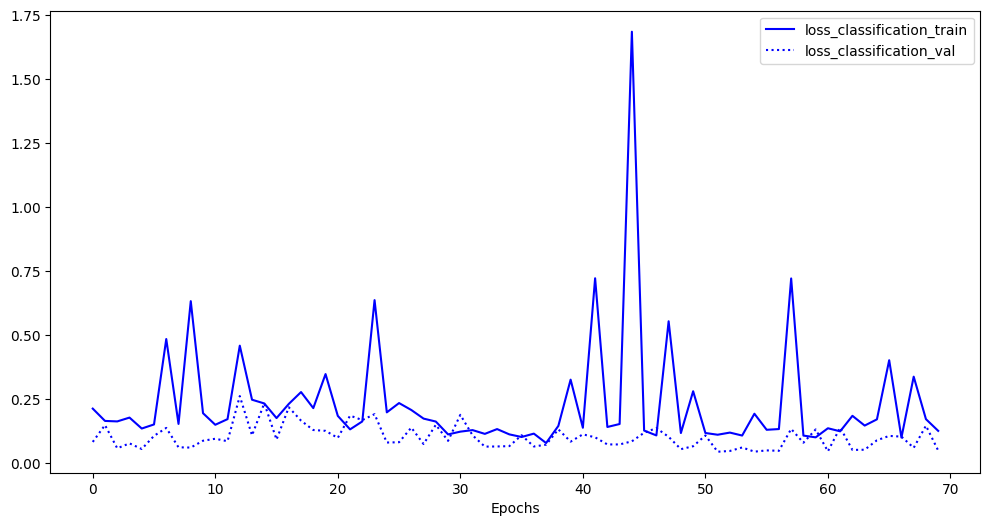

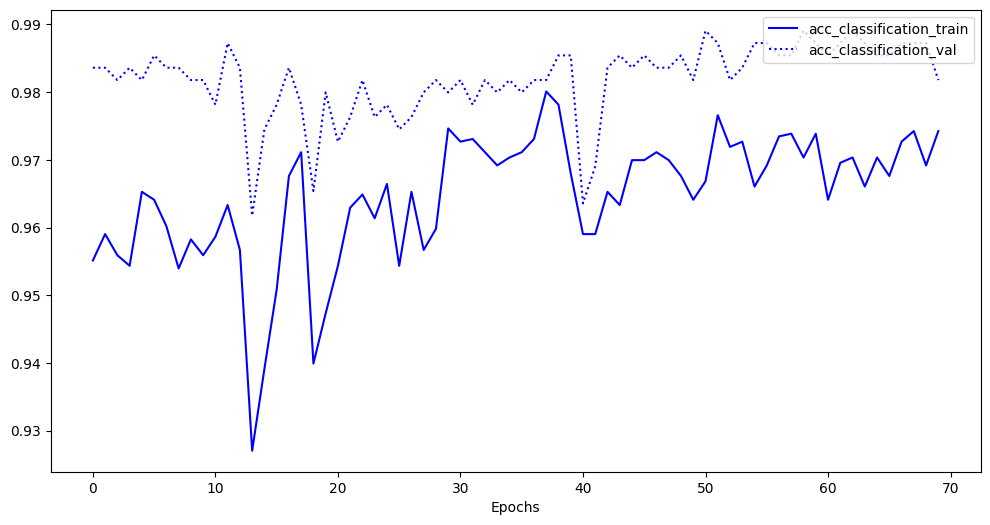

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

per class precision: [0.98892989 0.98924731]
per class recall: [0.98892989 0.98924731]
per class f1_score: [0.98892989 0.98924731]
average scores >>> precision: 0.989088600563425 | recall: 0.989088600563425 | f1_score: 0.989088600563425
accuracy: 0.9890909090909091
QWK:  0.97817720112685


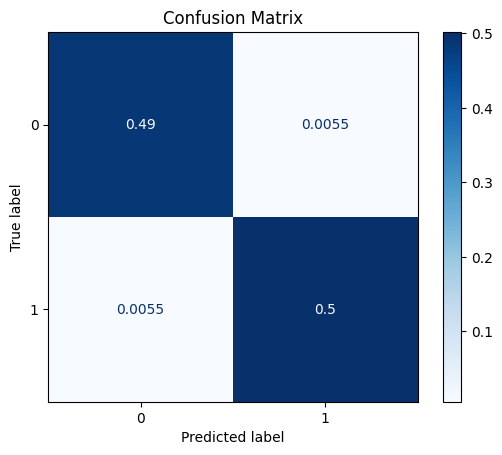

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            device=device,
            th=th)

per class precision: [0.99759423 0.98556231]
per class recall: [0.98495645 0.99769231]
per class f1_score: [0.99123506 0.99159021]
average scores >>> precision: 0.9915782680865689 | recall: 0.9913243802911261 | f1_score: 0.9914126369141172
accuracy: 0.9914163090128756
QWK:  0.9828259434065707


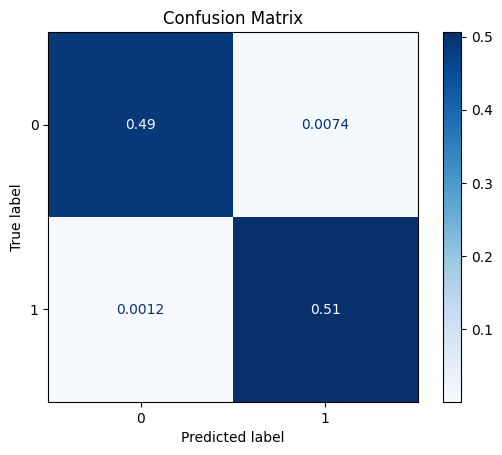

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_train_dataloader,
            device=device,
            th=th)

per class precision: [0.73053435 0.86175115]
per class recall: [0.94100295 0.51444292]
per class f1_score: [0.82251826 0.64427218]
average scores >>> precision: 0.7961427516093855 | recall: 0.7277229329730213 | f1_score: 0.733395221507473
accuracy: 0.7631880733944955
QWK:  0.483212173219262


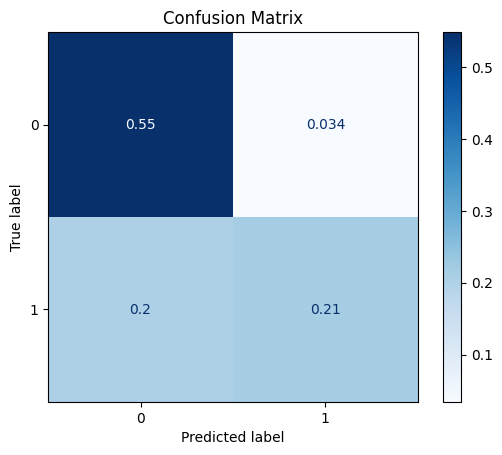

In [ ]:
MESSIDOR_test_results = engine.test_step(model=model,
            dataloader=MESSIDOR_dataloader,
            device=device,
            th=th)

per class precision: [0.85833333 0.92238806]
per class recall: [0.79844961 0.94785276]
per class f1_score: [0.82730924 0.93494705]
average scores >>> precision: 0.8903606965174129 | recall: 0.8731511865696485 | f1_score: 0.881128143436074
accuracy: 0.9054945054945055
QWK:  0.762373231311107


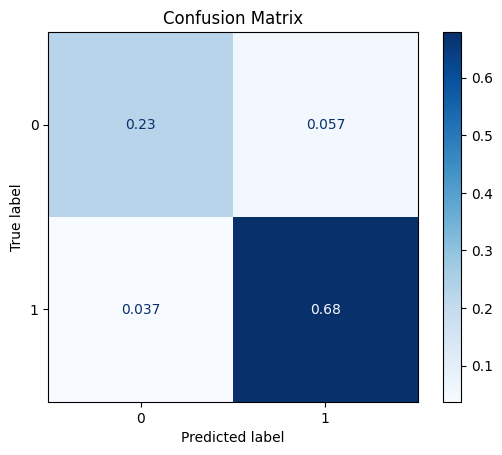

In [ ]:
IDRID_test_results = engine.test_step(model=model,
            dataloader=IDRID_dataloader,
            device=device,
            th=th)

In [ ]:
APTOS_15_test_results = engine.test_step(model=model,
            dataloader=APTOS_15_test_dataloader,
            device=device,
            th=th)

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=test_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)